# US Accident Dataset 2016-2023

## Data Collection (Raw Data)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#sklearn helpers/analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [24]:
#Some visualization settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-white')

/var/folders/6_/q20l7nsd6q93lk54vxqvb3x00000gn/T/ipykernel_20615/4092719186.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [25]:
df = pd.read_csv('data/US_Accidents_March23.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

There are a total of 45 data features in this dataset not including the index. Reporting this info will help us understand what features may be useful for our analysis. For example, we have a data frame for Start_Time and End_Time object types. From this we can actually expand the features to include the year, month, day, weekday, and hour of the accident.

### Expanding the Data (Time Duration)

In [26]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

timeduration = 'Time_Duration(td)'
df[timeduration]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
#Show these new columns added
df[['Start_Time','End_Time','Year','Month','Day','Hour','Weekday',timeduration]].head(5)

,Start_Time,End_Time,Year,Month,Day,Hour,Weekday,Time_Duration(td)
0,2016-02-08 05:46:00,2016-02-08 11:00:00,2016.0,Feb,8.0,5.0,Mon,314.0
1,2016-02-08 06:07:59,2016-02-08 06:37:59,2016.0,Feb,8.0,6.0,Mon,30.0
2,2016-02-08 06:49:27,2016-02-08 07:19:27,2016.0,Feb,8.0,6.0,Mon,30.0
3,2016-02-08 07:23:34,2016-02-08 07:53:34,2016.0,Feb,8.0,7.0,Mon,30.0
4,2016-02-08 07:39:07,2016-02-08 08:09:07,2016.0,Feb,8.0,7.0,Mon,30.0


Awesome now can move on to cleaning the data up and preparing it for analysis/training. First we will check for negative time durations and clean up any outliers.

In [27]:
x=0
if df[timeduration].isnull().values.any():
    x +=1
print(f'There are {x-1} records where Time_Duration is negative')
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df[timeduration].max(),round(df[timeduration].max()/60), round(df[timeduration].max()/60/24), df[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df[timeduration].median(),round(df[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df[timeduration].mean()),round(df[timeduration].mean()/60)))


There are 0 records where Time_Duration is negative
Max time to clear an accident: 2812939.0 minutes or 46882 hours or 1953 days; Min to clear an accident time: 1.0 minutes.
The median time to clear an accident is 63.0 minutes or 1 hours.
The average time to clear an accident is 427 minutes or 7 hours.


In [28]:
#Find outliers and replace with median
range=3
median = df[timeduration].median()
std = df[timeduration].std()
outliers = (df[timeduration] - median).abs() > std*range
df[outliers] = np.nan
df[timeduration].fillna(median, inplace=True)

/var/folders/6_/q20l7nsd6q93lk54vxqvb3x00000gn/T/ipykernel_20615/1840831224.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df[outliers] = np.nan


In [29]:
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident time: {} minutes.'.format(df[timeduration].max(),round(df[timeduration].max()/60), round(df[timeduration].max()/60/24), df[timeduration].min()))
print('The median time to clear an accident is {} minutes or {} hours.'.format(df[timeduration].median(),round(df[timeduration].median()/60)))
print('The average time to clear an accident is {} minutes or {} hours.'.format(round(df[timeduration].mean()),round(df[timeduration].mean()/60)))

Max time to clear an accident: 39753.0 minutes or 663 hours or 28 days; Min to clear an accident time: 1.0 minutes.
The median time to clear an accident is 63.0 minutes or 1 hours.
The average time to clear an accident is 110 minutes or 2 hours.


### Label Encoding

In [30]:
from sklearn.preprocessing import OrdinalEncoder
df_tennessee = df[(df['State']=='TN')]
df_sample = df_tennessee.sample(frac=0.1, random_state=42)
df_sample.dropna(inplace=True)
categorical_cols = df_sample.select_dtypes(include=['object','bool','category']).columns
label_encoder = LabelEncoder()

for col in categorical_cols:
    df_sample[col] = label_encoder.fit_transform(df_sample[col])

After label encoding the string value features, we can now take a look at the correlation between the features and the severity of the accident. This will help us determine which features are most important for our analysis.

## Feature Extraction

We begin by looking for the most correlated features in the dataset with respect to accident severity

In [31]:
corr_matrix = df_tennessee.corr()
#List the most highly correlated columns
print(corr_matrix['Severity'].sort_values(ascending=False))
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
#Make figure bigger
plt.figure(figsize=(50,50))
plt.show()

ValueError: could not convert string to float: 'A-512287'

In [32]:
df_sample_extracted = df_sample.drop(['Civil_Twilight', 'Nautical_Twilight', 'Sunrise_Sunset','Astronomical_Twilight', 'End_Lat', 'End_Lng', 'Start_Time', 'End_Time', 'Description', 'Airport_Code', 'Turning_Loop', 'Country', 'ID'], axis=1)

We removed 'Civil_Twilight', 'Nautical_Twilight', 'Sunrise_Sunset','Astronomical_Twilight' because they had very little positive or negative correlation to the accident severity. 'End_Lat', 'End_Lng' were removed due to overlapping data already covered by 'Start_Lat' and 'Start_Lng'. 'Start_Time' and 'End_Time' were removed because it is covered by the added column of Time_Duration and not as important of a feature as 'Start_Time'. 'Description' was all string object data and is not able to be meaningfully encoded. 'Airport_Code' is non meaningful location data about the nearest airport which we have more granual data in the Latitude and Longitude columns. 'Turning_Loop', 'Country' were the same value for all 8 million entries so they were removed. 

## Other Insights into the Data

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
states = gpd.read_file('data\cb_2018_us_state_500k.shx')

#Function to create a map for a given severity
def create_severity_map(severity, color, marker, label, ax):
    geo_df[geo_df['Severity'] == severity].plot(ax=ax, markersize=10, color=color, marker=marker, label=label)

geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

fig, axs = plt.subplots(2, 2, figsize=(30,30))  

#Plot each severity on its own map
create_severity_map(1, '#5cff4a', 'o', 'Severity 1', axs[0, 0])
create_severity_map(2, '#ffb340', '+', 'Severity 2', axs[0, 1])
create_severity_map(3, '#ff1c1c', 'x', 'Severity 3', axs[1, 0])
create_severity_map(4, '#6459ff', 'v', 'Severity 4', axs[1, 1])

for ax in axs.flatten():
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])
    states.boundary.plot(ax=ax, color='black')
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

axs[0, 0].set_title('U.S. Accidents of Severity 1', size=20)
axs[0, 1].set_title('U.S. Accidents of Severity 2', size=20)
axs[1, 0].set_title('U.S. Accidents of Severity 3', size=20)
axs[1, 1].set_title('U.S. Accidents of Severity 4', size=20)
plt.tight_layout()
plt.show()


DriverError: data\cb_2018_us_state_500k.shx: No such file or directory

Dropping any NaN values

In [33]:
#Print number of entries with a NaN or empty value
#print('Number of NaN or empty values in each column:')
#for column in df_tn_extracted.columns:
#    print('{}: {}'.format(column, df_tn_extracted[column].isnull().sum()))
print('Number of NaN or empty values in each column:')
for column in df_sample_extracted.columns:
    print('{}: {}'.format(column, df_sample_extracted[column].isnull().sum()))

Number of NaN or empty values in each column:
Source: 0
Severity: 0
Start_Lat: 0
Start_Lng: 0
Distance(mi): 0
Street: 0
City: 0
County: 0
State: 0
Zipcode: 0
Timezone: 0
Weather_Timestamp: 0
Temperature(F): 0
Wind_Chill(F): 0
Humidity(%): 0
Pressure(in): 0
Visibility(mi): 0
Wind_Direction: 0
Wind_Speed(mph): 0
Precipitation(in): 0
Weather_Condition: 0
Amenity: 0
Bump: 0
Crossing: 0
Give_Way: 0
Junction: 0
No_Exit: 0
Railway: 0
Roundabout: 0
Station: 0
Stop: 0
Traffic_Calming: 0
Traffic_Signal: 0
Year: 0
Month: 0
Day: 0
Hour: 0
Weekday: 0
Time_Duration(td): 0


We decided to further remove Precipitation and Wind Chill due to almost a quarter of the data missing. We replaced the rest of the empty data entries with the median for each column

In [34]:
#f_tn_extracted = df_tn_extracted.drop('Wind_Chill(F)', axis=1)
#df_tn_extracted = df_tn_extracted.drop('Precipitation(in)', axis=1)
#Replace NaN or empty values with the median for each column
#for column in df_tn_extracted.columns:
#    df_tn_extracted[column].fillna(df_tn_extracted[column].median(), inplace=True)
#for column in df_tn_extracted.columns:
#    print('{}: {}'.format(column, df_tn_extracted[column].isnull().sum()))

df_tn_extracted = df_sample_extracted.drop('Wind_Chill(F)', axis=1)
df_tn_extracted = df_sample_extracted.drop('Precipitation(in)', axis=1)
#Replace NaN or empty values with the median for each column
for column in df_tn_extracted.columns:
    df_tn_extracted[column].fillna(df_tn_extracted[column].median(), inplace=True)
for column in df_tn_extracted.columns:
    print('{}: {}'.format(column, df_tn_extracted[column].isnull().sum()))


Source: 0
Severity: 0
Start_Lat: 0
Start_Lng: 0
Distance(mi): 0
Street: 0
City: 0
County: 0
State: 0
Zipcode: 0
Timezone: 0
Weather_Timestamp: 0
Temperature(F): 0
Wind_Chill(F): 0
Humidity(%): 0
Pressure(in): 0
Visibility(mi): 0
Wind_Direction: 0
Wind_Speed(mph): 0
Weather_Condition: 0
Amenity: 0
Bump: 0
Crossing: 0
Give_Way: 0
Junction: 0
No_Exit: 0
Railway: 0
Roundabout: 0
Station: 0
Stop: 0
Traffic_Calming: 0
Traffic_Signal: 0
Year: 0
Month: 0
Day: 0
Hour: 0
Weekday: 0
Time_Duration(td): 0


## Feature Reduction (t-SNE)

In [35]:
#Split the data into training, testing, and validation sets
X = df_tn_extracted.drop('Severity', axis=1)
y = df_tn_extracted['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=21)

In [36]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

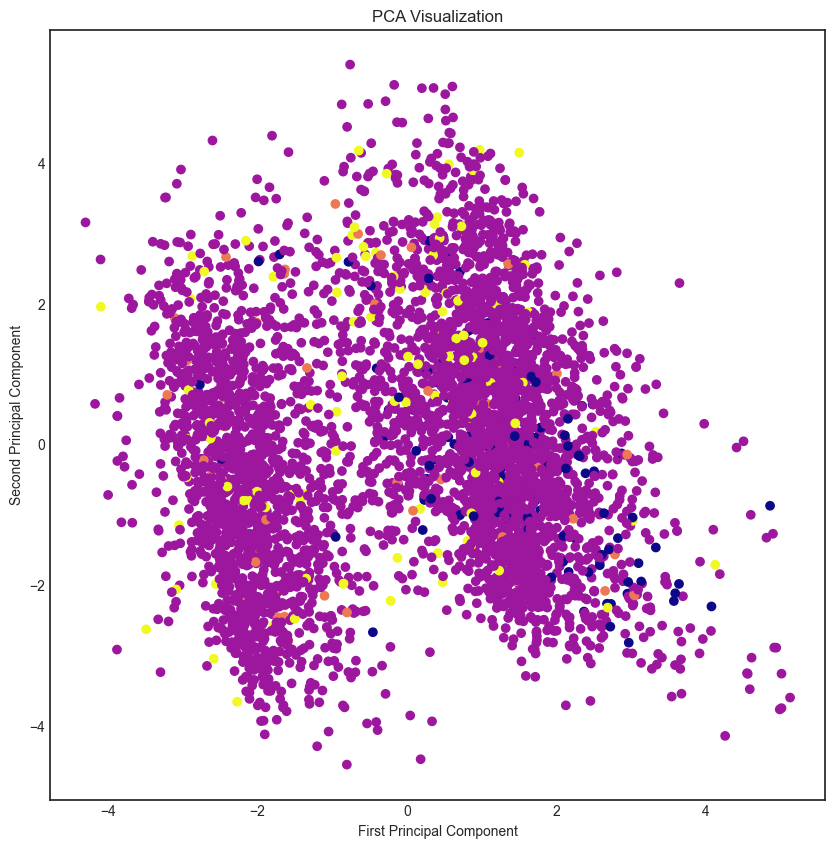

In [37]:
#Perform PCA
pca = PCA(n_components=20)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
#Plot the visualization
plt.figure(figsize=(10,10))
plt.scatter(pca_X_train[:,0], pca_X_train[:,1], c=y_train, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization')
plt.show()


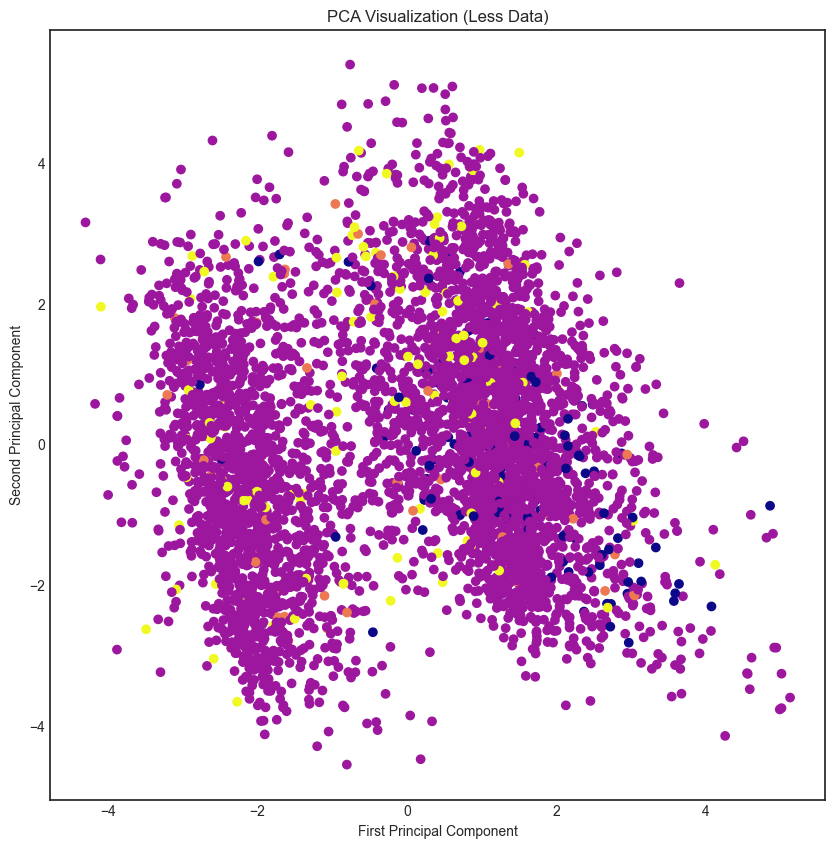

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(pca_X_train[:10000,0], pca_X_train[:10000,1], c=y_train[:10000], cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization (Less Data)')
plt.show()


In [39]:
#Perform PCA
pca = PCA(n_components=20)
pca.fit(X_test)
pca_X_test = pca.transform(X_test)

## Classification/Regression

### Minimum Mahalanobis Distance Classifier

In [42]:
from sklearn.neighbors import NearestCentroid
from scipy.spatial.distance import mahalanobis

def mahalanobis_metric(x, y):
    covariance_matrix = np.cov(pca_X_train[:100000], rowvar=False)
    inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
    return mahalanobis(x, y, inv_covariance_matrix)

# Initialize and train NearestCentroid with Mahalanobis distance
nc = NearestCentroid(metric=mahalanobis_metric)
nc.fit(pca_X_train[:100000], y_train[:100000])

# Predict on test data
y_pred = nc.predict(pca_X_test[:1000])

# Calculate accuracy
accuracy = accuracy_score(y_pred, y_test[:1000])
print(f'Accuracy: {accuracy*100}%')

/opt/homebrew/lib/python3.11/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


Accuracy: 57.72495755517827%


### Kmeans Classifier

In [47]:
#Implement kmeans as a classifier and test accuracy
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_X_train)
y_pred = kmeans.predict(pca_X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy*100}%')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 30.050933786078097%


### Decision Tree Regression

In [48]:
#Implement decision tree and report accuracy
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(pca_X_train[:1000000], y_train[:1000000])
y_pred = dtree.predict(pca_X_test[:1000])
accuracy = np.mean(y_pred == y_test[:1000])
print(f'Accuracy: {accuracy*100}%')

Accuracy: 75.38200339558574%


## Performance Evaluation